# Bambi Livestream

In [1]:
import pymc as pm
import bambi as bmb
import pandas as pd
import arviz as az

WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
pm.__version__

'4.0.0'

In [3]:
bmb.__version__

'0.9.0'

# TODO
* Run a test model first
* Load the data from Causal Inf mixtape
* Run the regression that is shown in the book
    
## More goals
* Show the difference between fully declared PyMC Model
* Explain ArviZ Plots
* Show the model graph output


## Palmer Penguin Dataset

In [4]:
url = "https://gist.githubusercontent.com/slopp/ce3b90b9168f2f921784de84fa445651/raw/4ecf3041f0ed4913e7c230758733948bc561f434/penguins.csv"

In [5]:
penguins = pd.read_csv(url)

In [6]:
penguins.head()

,rowid,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,4,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


## Complete Case Analysis

In [7]:
missing_data = penguins.isnull()[
    ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "sex", "body_mass_g"]
].any(axis=1)
# Drop rows with any missing data
penguins = penguins.loc[~missing_data]

## Get a Bambi model running
* `bill_length_mm ~ bill_depth_mm

In [8]:
model = bmb.Model("bill_length_mm ~ bill_depth_mm", penguins)
fitted = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, bill_depth_mm, bill_length_mm_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 43 seconds.


In [9]:
model

Formula: bill_length_mm ~ bill_depth_mm
Family name: Gaussian
Link: identity
Observations: 333
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 43.9928, sigma: 119.9486)
    bill_depth_mm ~ Normal(mu: 0.0, sigma: 6.9426)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 5.4605)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [10]:
fitted

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

### MCMC Diagnostic Plot
We want this plot because it lets us know if we can trust the results of Markov Chain Monte Carlo

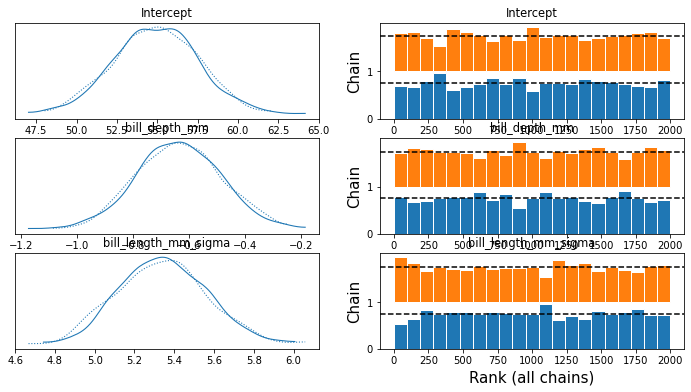

In [11]:
az.plot_trace(fitted, kind="rank_bars");

## Results plot

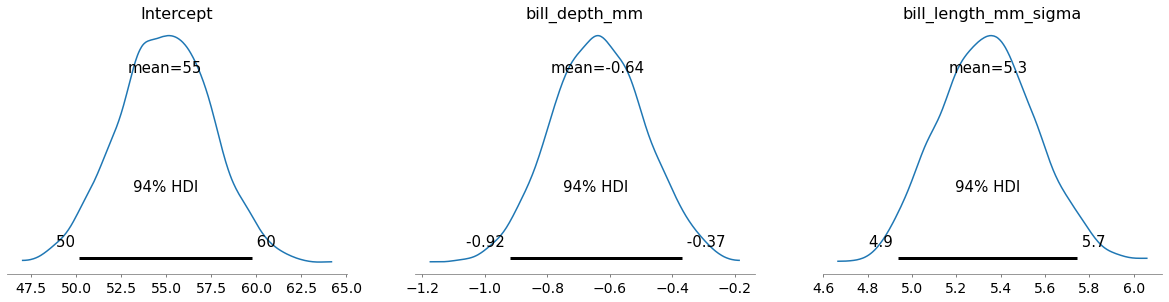

In [12]:
az.plot_posterior(fitted);

## Model Graph Output

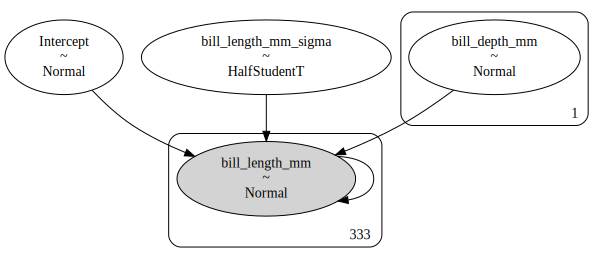

In [13]:
model.graph()

## Full PyMC Model (TODO For you folks)

In [17]:
adelie_mask = (penguins["species"] == "Adelie")
adelie_mass_obs = penguins.loc[adelie_mask, "body_mass_g"].values

adelie_flipper_length = penguins.loc[adelie_mask, "flipper_length_mm"]

# adelie_flipper_length_obs = penguins.loc[adelie_mask, "flipper_length_mm"]


In [19]:
with pm.Model() as model_adelie_flipper_regression:
   
    σ = pm.HalfStudentT("σ", 100, 2000)
    β_0 = pm.Normal("β_0", 0, 4000)
    β_1 = pm.Normal("β_1", 0, 4000)
    μ = pm.Deterministic("μ", β_0 + β_1 * adelie_flipper_length.values)

    mass = pm.Normal("mass", mu=μ, sigma=σ, observed = adelie_mass_obs)

    inf_data_adelie_flipper_regression = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β_0, β_1]


ValueError: Not enough samples to build a trace.

## Bambi Model

In [ ]:
model = bmb.Model("adelie_mass_obs ~ flipper_length_mm", adelie_flipper_length_obs)
fitted = model.fit()

# Causal Inf Mixtape Example

In [21]:
book_url = "https://raw.github.com/scunning1975/mixtape/master/auto.dta"

In [22]:
cars = pd.read_stata(book_url)

In [23]:
cars.head()

,make,price,mpg,rep78,headroom,trunk,weight,length,turn,displacement,gear_ratio,foreign
0,AMC Concord,4099,22,3.0,2.5,11,2930,186,40,121,3.58,Domestic
1,AMC Pacer,4749,17,3.0,3.0,11,3350,173,40,258,2.53,Domestic
2,AMC Spirit,3799,22,NaN,3.0,12,2640,168,35,121,3.08,Domestic
3,Buick Century,4816,20,3.0,4.5,16,3250,196,40,196,2.93,Domestic
4,Buick Electra,7827,15,4.0,4.0,20,4080,222,43,350,2.41,Domestic


## Run a regression

In [26]:
model = bmb.Model("price ~ length", cars)
fitted = model.fit(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, length, price_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 42 seconds.


In [27]:
model

Formula: price ~ length
Family name: Gaussian
Link: identity
Observations: 74
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 6165.2568, sigma: 62665.299)
    length ~ Normal(mu: 0.0, sigma: 331.1608)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 2929.4991)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

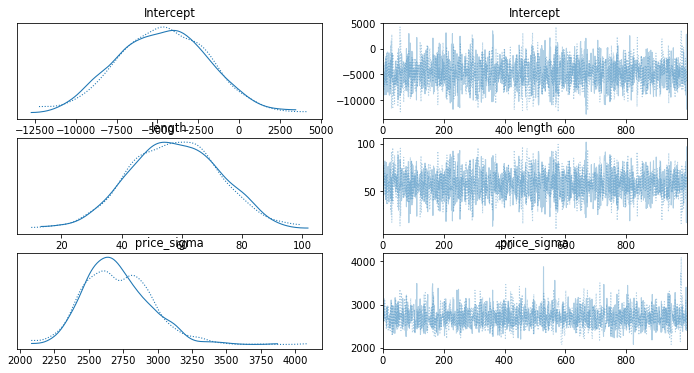

In [30]:
az.plot_trace(fitted);

In [31]:
az.summary(fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-4665.773,2814.458,-10018.790,480.202,53.544,45.252,2751.0,1172.0,1.0
length,57.587,14.853,29.177,83.798,0.280,0.208,2807.0,1051.0,1.0
price_sigma,2708.260,238.013,2322.202,3167.660,4.993,3.568,2302.0,1311.0,1.0


## Longer regression

In [34]:
model_2 = bmb.Model("price ~ length + weight + headroom + mpg", cars)
fitted_2 = model_2.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, length, weight, headroom, mpg, price_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 84 seconds.


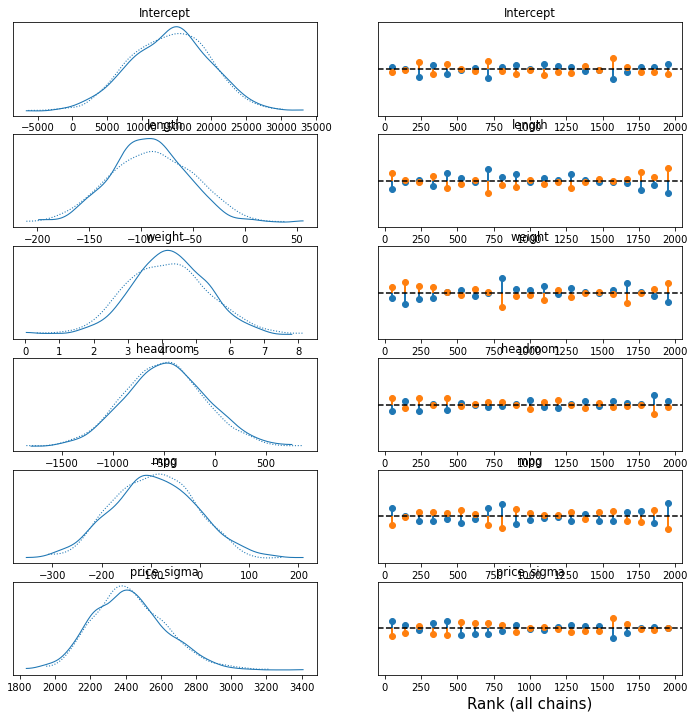

In [38]:
az.plot_trace(fitted_2, kind="rank_vlines");

In [36]:
az.summary(fitted_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,13978.588,5756.304,3587.769,24619.785,149.925,106.034,1481.0,1237.0,1.0
length,-90.664,39.651,-164.118,-18.764,1.191,0.843,1141.0,951.0,1.0
weight,4.190,1.181,2.134,6.557,0.035,0.025,1162.0,1057.0,1.0
headroom,-487.601,398.971,-1174.606,310.493,9.328,7.209,1833.0,1234.0,1.0
mpg,-92.304,83.615,-237.691,66.605,2.078,1.545,1627.0,1240.0,1.0
price_sigma,2429.212,213.232,2072.698,2844.110,6.172,4.372,1183.0,784.0,1.0


In [49]:
from bambi.plots import plot_cap
import matplotlib.pyplot as plt

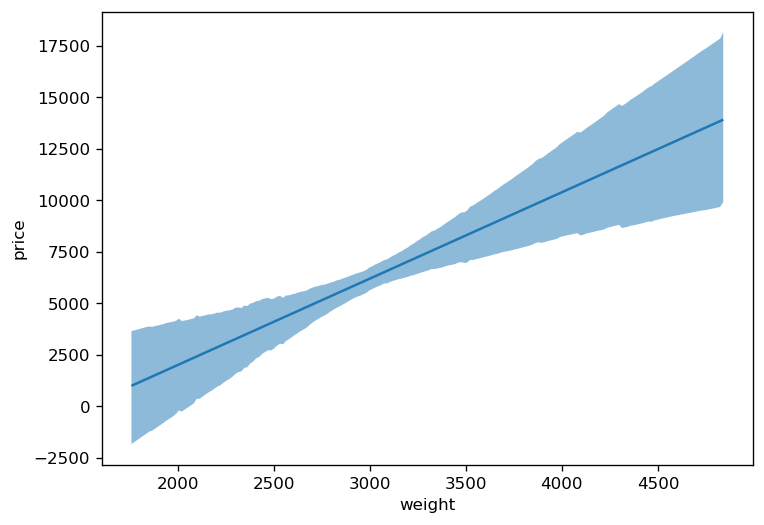

In [51]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=120)
plot_cap(model_2, fitted_2, "weight", ax=ax);